# 75 Articles by inclusion/exclusion criteria with 100% researcher agreement
These include Surveys and Position Papers

### Include criteria
* must be a combination of neural and symbolic techniques (NOT comaparisons of same, NOT ensembles of each)
* must be text as input

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
from wordcloud import WordCloud
import utils
import umap
import hdbscan
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/kylehamilton/MyDocuments/ML-Labs/neuro-symbolic-AI/neuro-symbolic-ai-systematic-review/scopus/utils.py'>

In [2]:
import matplotlib as mpl
plt.style.use('presentation.mplstyle')
mpl.matplotlib_fname()

'/Users/kylehamilton/MyDocuments/ML-Labs/neuro-symbolic-AI/neuro-symbolic-ai-systematic-review/scopus/matplotlibrc'

In [8]:
df233=pd.read_csv("scopus (233).csv")

In [ ]:
df233.columns
# keys=scopus[['Key','DOI']]

In [258]:
df75=pd.read_csv("agreed75.csv")

In [259]:
df75.columns

Index(['Key', 'DOI', 'Publication Title', 'Publication Year', 'Title_x',
       'symbolic', 'NN', 'comments'],
      dtype='object')

In [260]:
df=pd.merge(df233,df75,on="DOI",how='outer')

In [261]:
df=df[df['Key'].notnull()]

In [262]:
len(df)

76

In [124]:
df.columns

Index(['Authors', 'Author(s) ID', 'Title', 'Year', 'Source title', 'Volume',
       'Issue', 'Art. No.', 'Page start', 'Page end',
       ...
       'Unnamed: 1058', 'Unnamed: 1059', 'Unnamed: 1060', 'Key',
       'Publication Title', 'Publication Year', 'Title_x', 'symbolic', 'NN',
       'comments'],
      dtype='object', length=1068)

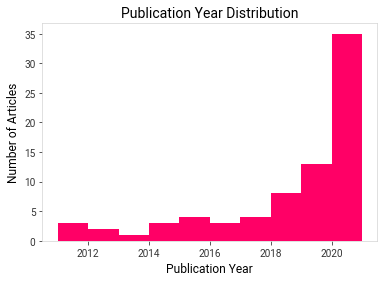

In [125]:
plt.hist(df['Publication Year'])
plt.title('Publication Year Distribution')
plt.xlabel('Publication Year')
plt.ylabel('Number of Articles')
plt.show()

In [5]:
def drawCloud(text):
    wc = WordCloud(background_color="white", 
                   max_words=350, 
                   width=1000, 
                   height=600, 
                   random_state=1).generate(text)

    plt.figure(figsize=(15,15))
    plt.imshow(wc)
    plt.axis("off")

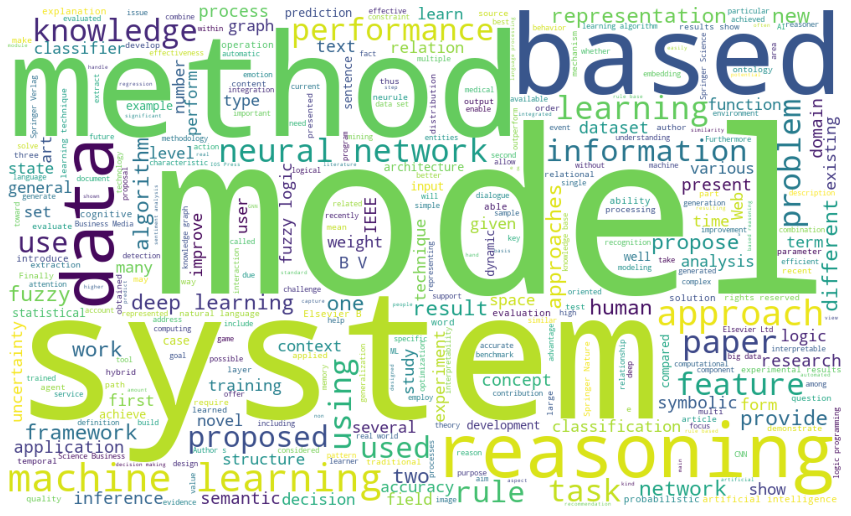

In [10]:
text = ','.join(list(df233['Abstract']))
drawCloud(text)

## Topics
Use raw text abstracts, or load previously trained embeddings

In [129]:
abstracts = np.array(df['Abstract'])

In [133]:
fileName='embeddings1633605755.583539.txt'
embeddings = np.loadtxt(fileName, delimiter=',')

In [130]:
importlib.reload(utils)
# defaults: make_clusters(data, neighbors=15, components=5, cluster_size=5, save_embeddings=False)
cluster = utils.make_clusters(abstracts,save_embeddings=True)


saving embeddings


In [131]:
set(cluster.labels_)

{-1, 0, 1, 2, 3}

## Visualise clusters

In [134]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

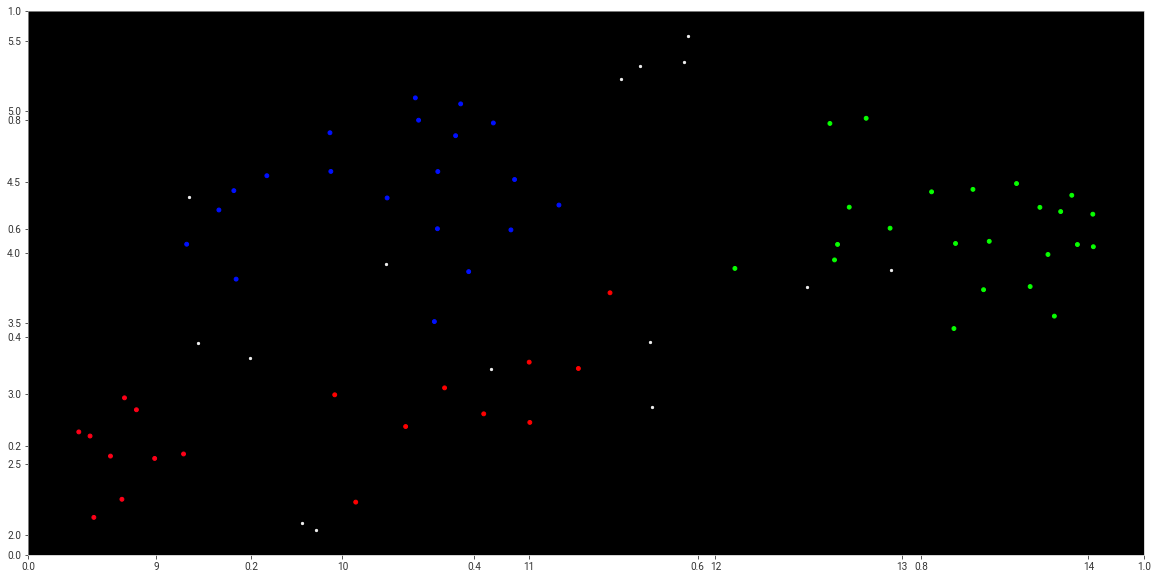

In [135]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
ax = fig.add_subplot(facecolor='#000000')
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#eeeeee', s=5)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=15, cmap='hsv_r')
plt.show()

## Topic keywords

In [136]:
importlib.reload(utils)

<module 'utils' from '/Users/kylehamilton/MyDocuments/ML-Labs/neuro-symbolic-AI/neuro-symbolic-ai-systematic-review/scopus/utils.py'>

In [137]:
top_n_words, topic_sizes = utils.get_topics(cluster, abstracts)

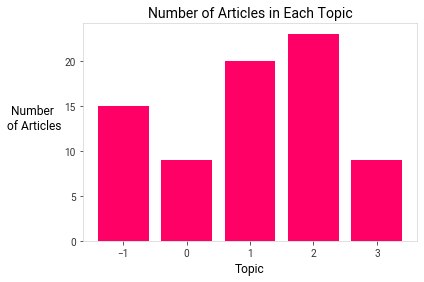

In [138]:
fig, ax = plt.subplots()
plt.bar(topic_sizes['Topic'],topic_sizes['Size'])
plt.title('Number of Articles in Each Topic')
plt.xlabel('Topic')
plt.ylabel('Number \nof Articles',rotation=0,labelpad=30)
plt.show()

In [139]:
# -1 topic are outliers (not part of any topic)

for i in range(0,len(topic_sizes-1)):
    print("Topic: ",topic_sizes["Topic"].iloc[i], "| Size: ", topic_sizes["Size"].iloc[i])
    print("_"*50)
    for j in top_n_words[i-1][:10]:
        print(j[0])
    print("="*50)

Topic:  2 | Size:  23
__________________________________________________
fake
multi
people
news
automata
gp
actions
tl
respective
malicious
Topic:  1 | Size:  20
__________________________________________________
sentiment
job
fdlc
rate
negative
positive
emotion
cnn
social
platforms
Topic:  -1 | Size:  15
__________________________________________________
question
relations
dialogue
path
titan
answering
cognitive
argumentation
graph
relation
Topic:  0 | Size:  9
__________________________________________________
rule
kernel
ec
functions
interpretable
intelligent
selection
attributes
relational
output
Topic:  3 | Size:  9
__________________________________________________
idf
relevance
generalization
xml
neutrosophic
document
sentences
term
summarization
abstractive


# Citation networks
Create a citation graph based on authors (not papers). Use it to find most "infuential" authors by performing PageRank

In [17]:
# df['References']

In [263]:
# we only care about authors and references for this graph.
dfc=df[['Authors','References']]

In [264]:
# authors are separated by a comma. Create a list by splitting on ,
df_auth=df[['Authors','References']]
df_auth['Authors']=df_auth['Authors'].str.split(pat=",")

/Users/kylehamilton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [265]:
# put each author in their own row
df_auth=df_auth.set_index(['References']).apply(pd.Series.explode).reset_index()

In [266]:
df_auth['References']=1

## Authors with most articles

In [267]:
auth_count=df_auth.groupby(['Authors']).count().reset_index()
auth_count=auth_count.sort_values(by='References', ascending=False)
auth_count=auth_count[auth_count['References']>1]
auth_count.rename(columns = {'References': 'Article Count', 'Authors': 'Author'}, inplace = False).head(10)
# plt.bar(auth_count['ref_Author'],auth_count['Authors'])

,Author,Article Count
182,Wang H.,3
17,Cambria E.,3
168,Stolzenburg F.,2
102,Liu Y.,2
272,Riveret R.,2
241,Galitsky B.,2
61,Hair A.,2
204,Yang J.-B.,2
133,Pitt J.,2
135,Qadir J.,2


In [268]:
# references are separated by a semi-colon. Create a list by splitting on ;
dfc['References']=dfc['References'].str.split(pat=";")

/Users/kylehamilton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [269]:
# put each citation in its own row
dfc=dfc.set_index(['Authors']).apply(pd.Series.explode).reset_index()

### Get the author names from the citation
`(([À-ŽA-z|\-|\']\s?)+,?\s(\-?[À-Ž|A-Z]\.)+)\,`   
As far as I can tell, this captures the author names pretty well:
<img src="authors-regex-example.jpg">

In [270]:
# Extracts authors from the references and creates new row for each
dfc[['ref_Id','match','ref_Author']]=dfc['References'].str.extractall(pat=r"(([À-ŽA-z|\-|\']\s?)+,?\s(\-?[À-Ž|A-Z]\.)+)\,").reset_index()[['level_0','match',0]]

In [271]:
# remove redundant columns
dfc=dfc[['Authors','ref_Id','ref_Author']]

In [272]:
# authors are separated by a comma. Create a list by splitting on ,
dfc['Authors']=dfc['Authors'].str.split(pat=",")

## Authors most frequently referenced

In [274]:
ref_auth_count=dfc.groupby(['ref_Author']).count().sort_values(by='Authors', ascending=False)
ref_auth_count=ref_auth_count.reset_index()
ref_auth_count.rename(columns = {'Authors': 'Number of times referenced','ref_Author':'Referenced Author'}, inplace = False).drop(['ref_Id'],axis=1)
# plt.bar(auth_count['ref_Author'],auth_count['Authors'])

,Referenced Author,Number of times referenced
0,"Yang, J.B.",16
1,"Socher, R.",11
2,"Mikolov, T.",11
3,"Li, J.",11
4,"Liu, Z.",10
...,...,...
2413,"Hong, J.",1
2414,"Holsapple, C.W.",1
2415,"Hollander, B.",1
2416,"Holland, J.H.",1


In [280]:
# put each author in their own row
dfc=dfc.set_index(['ref_Id','ref_Author']).apply(pd.Series.explode).reset_index()

In [281]:
# now we have a cartesian-join of authors 
# dfc

In [282]:
# remove commas from the ref_Author so the format matches that of Authors
dfc['ref_Author'].replace(',','', regex=True, inplace=True)

In [283]:
ref_author_nodes=dfc['ref_Author'].unique()

In [284]:
author_nodes=dfc['Authors'].unique()

In [285]:
# author_nodes

In [286]:
a_nodes=len(author_nodes)

In [287]:
ra_nodes=len(ref_author_nodes)

In [288]:
# Cross reference authors
# set(ref_author_nodes).intersection(set(author_nodes))

In [289]:
int_nodes=len(set(ref_author_nodes).intersection(set(author_nodes)))

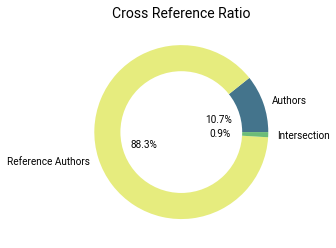

In [290]:
Keys = ['Authors', 'Reference Authors', 'Intersection']
Values = [a_nodes, ra_nodes, int_nodes]
colors = ['#44748c', '#e6ec7e','#6cbc78']

plt.pie(Values, colors=colors, labels=Keys,
        autopct='%1.1f%%', pctdistance=.45)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Cross Reference Ratio')
plt.show()

In [169]:
# !pip install matplotlib-venn

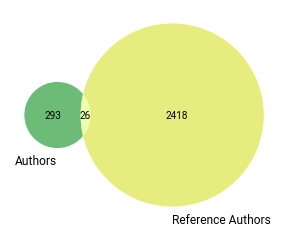

In [193]:
from matplotlib_venn import venn2
venn2(subsets = (a_nodes, ra_nodes, int_nodes), set_labels = ('Authors', 'Reference Authors'), alpha=1, set_colors=('#6cbc78', '#e6ec7e'),)
plt.show()

In [291]:
# group by author, concatenate ref_author
dfc=dfc.groupby(['Authors'], as_index = False).agg({'ref_Author': ','.join})

In [293]:
# dfc

In [294]:
import csv
dfc.to_csv('authors75.adjlist', index=False,header=False, quoting=csv.QUOTE_NONE, quotechar='',escapechar=' ')

## To do a paper citation network, extract the paper titles instead of the authors from the citations

In [196]:
pd.set_option('display.max_colwidth', None)

In [297]:
dft=df.copy()

In [298]:
dft=dft[['Title','References']]

In [299]:
#references are separated by a semi-colon. Create a list by splitting on ;
dft['References']=dft['References'].str.split(pat=";")

In [300]:
# put each citation in its own row
dft=dft.set_index(['Title']).apply(pd.Series.explode).reset_index()

In [180]:
dft

,Title,References
0,Detecting malicious behavior in social platforms via hybrid knowledge- and data-driven systems,"Paredes, J.N., Simari, G.I., Martinez, M.V., Falappa, M.A., Netder: An architecture for reasoning about malicious behavior (2021) Inform. Syst. Front., 23 (1), pp. 185-201"
1,Detecting malicious behavior in social platforms via hybrid knowledge- and data-driven systems,"Shao, C., Ciampaglia, G.L., Varol, O., Flammini, A., Menczer, F., The spread of fake news by social bots (2017), pp. 96-104. , ArXiv Preprint"
2,Detecting malicious behavior in social platforms via hybrid knowledge- and data-driven systems,"Agarwal, R., Barve, S., Shukla, S.K., Detecting malicious accounts in permissionless blockchains using temporal graph properties (2020), CoRR abs/2007.05169"
3,Detecting malicious behavior in social platforms via hybrid knowledge- and data-driven systems,"Spagnuolo, M., Maggi, F., Zanero, S., Bitiodine: Extracting intelligence from the bitcoin network (2014) Financial Cryptography and Data Security - 18th International Conference, FC 2014, Christ Church, Barbados, March 3-7, 2014, Revised Selected Papers, Lecture Notes in Computer Science, 8437, pp. 457-468. , Christin N. Safavi-Naini R. Springer"
4,Detecting malicious behavior in social platforms via hybrid knowledge- and data-driven systems,"Calì, A., Gottlob, G., Lukasiewicz, T., A general datalog-based framework for tractable query answering over ontologies (2012) J. Web Semant., 14, pp. 57-83"
...,...,...
3280,On the predictive analysis of behavioral massive job data using embedded clustering and deep recurrent neural networks,"Megalooikonomou, V., Wang, Q., Li, G., Faloutsos, C., A multiresolution symbolic representation of time series (2005) Proceedings of the International Council for Open and Distance Education, ICDE, pp. 668-679"
3281,On the predictive analysis of behavioral massive job data using embedded clustering and deep recurrent neural networks,"Macqueen, J.B., Some methods of classification and analysis of multivariate observations (1967) Proceedings of the Fifth Berkeley Symposium on Mathematical Statistics and Probability, MSP, pp. 281-297"
3282,On the predictive analysis of behavioral massive job data using embedded clustering and deep recurrent neural networks,"Turenne, N., (2016), Analyse de données textuelles sous R. ISTE Editions, 318 p., Collection Sciences cognitives (ISTE), 978-1-78406-107-4 (ebook)"
3283,On the predictive analysis of behavioral massive job data using embedded clustering and deep recurrent neural networks,"http://www.philippe-fournier-viger.com/spmf/index.php?link=documentation.php#cptplus, Open data mining library, howpublished ="


In [48]:
# Everything between the last comma and the first parentheses (sadly includes the comma, so remove it in second step)
# (?:.(?!\,))+?(?=\()

In [301]:
dft['References']=dft['References'].str.extract(pat=r"((?:.(?!\,))+?(?=\())")
dft['References']=dft['References'].str.replace(',\s','', regex=True)

In [302]:
dft['Title']=dft['Title'].str.lower()
dft['References']=dft['References'].str.lower()
dft['Title']=dft['Title'].str.strip()
dft['References']=dft['References'].str.strip()

In [303]:
# Cross referenced articles (These are articles in all the references which are also in the primary list of articles)
int_titles=len(set(dft['Title']).intersection(set(dft['References'])))

In [304]:
titles=len(set(dft['Title']))

In [305]:
ref_titles=len(set(dft['References']))

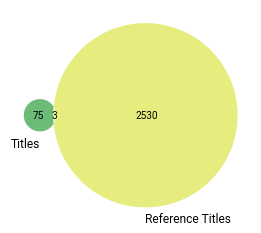

In [306]:
from matplotlib_venn import venn2
venn2(subsets = (titles, ref_titles, int_titles), set_labels = ('Titles', 'Reference Titles'), alpha=1, set_colors=('#6cbc78', '#e6ec7e'),)
plt.show()

# Graph Analysis

In [307]:
import networkx as nx

In [308]:
G = nx.read_adjlist("authors75.adjlist", delimiter=",", create_using=nx.DiGraph)

In [309]:
nx.info(G)

'Name: \nType: DiGraph\nNumber of nodes: 2736\nNumber of edges: 11614\nAverage in degree:   4.2449\nAverage out degree:   4.2449'

In [310]:
# sanity check
nx.is_directed(G)

True

In [311]:
nx.number_connected_components(G.to_undirected())

4

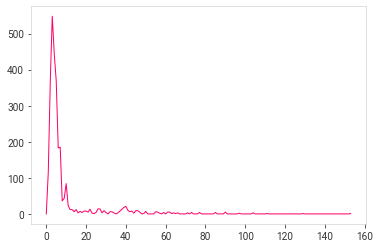

In [312]:
plt.plot(nx.degree_histogram(G))

## In-degree centrality

In [313]:
in_deg=nx.in_degree_centrality(G)

In [314]:
in_degTups=[(k,v) for k,v in in_deg.items()]
in_degDF=pd.DataFrame.from_records(in_degTups,columns=['author','in-degree'])

# Top 10 Authors by indegree
in_degDF.sort_values(by='in-degree',ascending=False).head(10)

,author,in-degree
515,Bengio Y.,0.011700
268,Li J.,0.010969
57,Liu Z.,0.010603
59,Liu Y.,0.009872
598,Mikolov T.,0.009872
546,Zhang Y.,0.009872
15,Chen Y.,0.009506
429,De Raedt L.,0.009506
67,Tang J.,0.009141
60,Zhu X.,0.009141


In [315]:
list(nx.all_neighbors(G, 'Bengio  Y. '))

['Cai  Q.',
 'Chen  S.-M.',
 'Er  M.J.',
 'García-Castro  R.',
 'Lavrač  N.',
 'Liang  X.',
 'Lu  J.',
 'Lughofer  E.',
 'Martinc  M.',
 'Mi  K.',
 'Munir  R.F.',
 'Pollak  S.',
 'Qayyum  Z.U.',
 'Safyan  M.',
 'Shen  B.',
 'Si  C.',
 'Siebert  S.',
 'Stolzenburg  F.',
 'Tang  J.',
 'Wang  T.',
 'Xia  C.',
 'Yao  B.',
 'Zhang  G.',
 'Zhang  Z.',
 'Liu  H.',
 'Liu  N.',
 'Liu  W.',
 'Pratama  M.',
 'Sarwar  S.',
 'Schon  C.',
 'Wang  Y.',
 'Škrlj  B.']

## PageRank centrality

In [316]:
pagerank=nx.pagerank(G)

In [317]:
pagerankTups=[(k,v) for k,v in pagerank.items()]

In [318]:
pagerankDF=pd.DataFrame.from_records(pagerankTups,columns=['author','pr'])

In [319]:
# Top 10 Authors
pagerankDF.sort_values(by='pr',ascending=False).head(10)

,author,pr
1728,Burns R.S.,0.003185
1863,Khan A.,0.002045
2189,Mitchell T.M.,0.001522
1115,Sun Z.,0.001205
1859,Ji G.,0.001190
6,Riedel S.,0.000600
3,He X.,0.000563
268,Li J.,0.000550
67,Tang J.,0.000546
515,Bengio Y.,0.000543


# Keyword analysis

In [320]:
pd.set_option('display.max_colwidth', None)
dfk=df.copy()

In [321]:
dfk=dfk[['Author Keywords','Index Keywords']]
dfk=dfk.dropna()

In [322]:
dfk=dfk.astype(str)
dfk['all_keywords']=dfk[['Author Keywords','Index Keywords']].agg(';'.join, axis=1)
dfk = dfk.reset_index()
dfk = dfk.set_index('index').reset_index()

In [323]:
dfk['all_keywords']=dfk['all_keywords'].str.split(pat=";")

In [324]:
dfk=dfk.set_index(['index']).apply(pd.Series.explode).reset_index()

In [325]:
dfk=dfk[['index','all_keywords']]

In [326]:
dfk=dfk.groupby('all_keywords').count().reset_index().sort_values(by='index', ascending=False)

In [327]:
# dfk=dfk[dfk['index']>15]

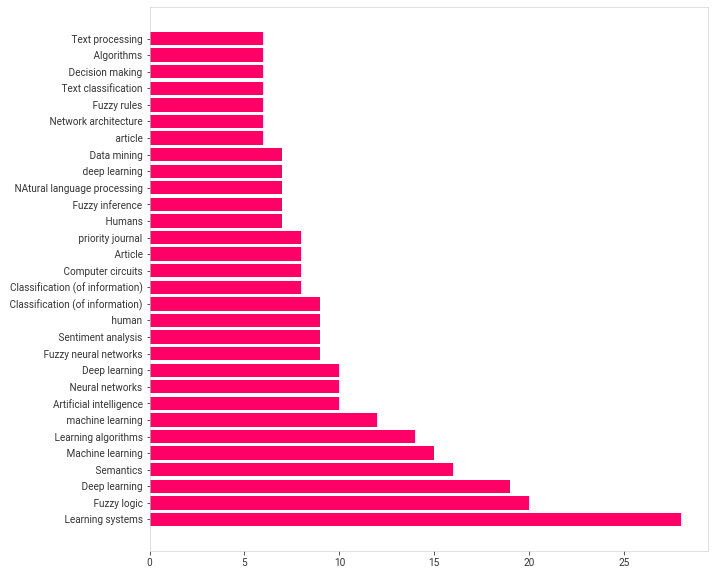

In [328]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.barh(dfk['all_keywords'].head(30),dfk['index'].head(30))
plt.show()

## Keyword wordcloud

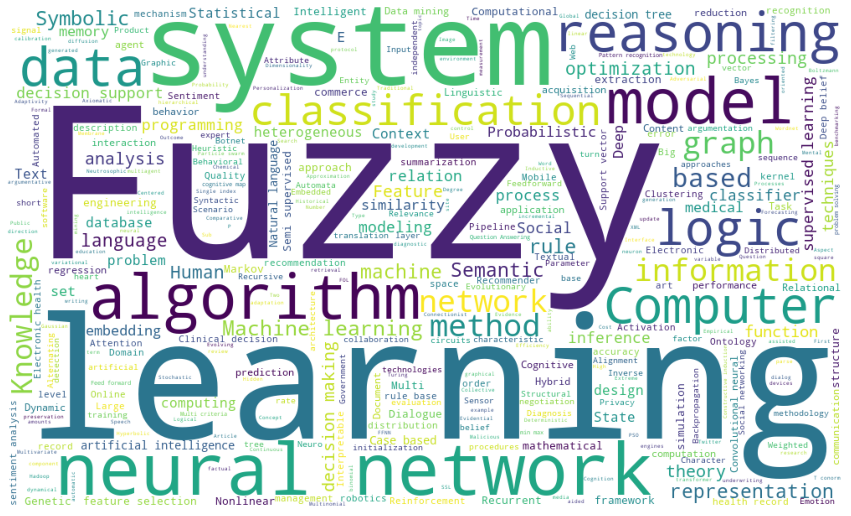

In [329]:
text = ','.join(list(dfk['all_keywords']))
drawCloud(text)

## Market-basket analysis on keywords
### Frequent itemsets

$$ Support=\frac{\#(X,Y)}{N} $$

$$ Confidence=\frac{\#(X,Y)}{\#(X)} $$

$$ Lift=\frac{Support}{Support(X)\times Support(Y)} $$

In [17]:
# !pip install mlxtend

In [239]:
pd.set_option('display.max_colwidth', None)
baskets=df

In [240]:
baskets=baskets[['Author Keywords','Index Keywords']]
baskets=baskets.dropna()

In [241]:
baskets=baskets.astype(str)
baskets['all_keywords']=baskets[['Author Keywords','Index Keywords']].agg(';'.join, axis=1)
baskets['Author Keywords']=baskets['Author Keywords'].map(lambda x: x.lower()).str.split(pat=";")
baskets['Index Keywords']=baskets['Index Keywords'].map(lambda x: x.lower()).str.split(pat=";")
baskets['all_keywords']=baskets['all_keywords'].map(lambda x: x.lower()).str.split(pat=";")

In [242]:
keywords='all_keywords'
dataset=baskets[keywords]

In [331]:
from mlxtend.frequent_patterns import fpgrowth,fpmax, apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
# http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
dff = pd.DataFrame(te_ary, columns=te.columns_)
# dff

In [333]:
# combination appears in <support> ratio of dataset, ie 0.05 means this combination of keywords appears in 5% of the dataset
support=0.05 
freq_items=fpgrowth(dff, min_support=support, use_colnames=True)

In [334]:
# for i in freq_items.sort_values(by='support',ascending=False)['itemsets']:
#     print(i)

In [335]:
rules = association_rules(freq_items, min_threshold=0.01)

In [336]:
rules.sort_values(by='support',ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
53,( learning systems),( fuzzy logic),0.400000,0.285714,0.171429,0.428571,1.500000,0.057143,1.250000
52,( fuzzy logic),( learning systems),0.285714,0.400000,0.171429,0.600000,1.500000,0.057143,1.500000
31,( machine learning),( learning algorithms),0.314286,0.200000,0.128571,0.409091,2.045455,0.065714,1.353846
30,( learning algorithms),( machine learning),0.200000,0.314286,0.128571,0.642857,2.045455,0.065714,1.920000
100,( priority journal),( article),0.114286,0.200000,0.114286,1.000000,5.000000,0.091429,inf
...,...,...,...,...,...,...,...,...,...
142,"( algorithms, machine learning)",( human),0.057143,0.128571,0.057143,1.000000,7.777778,0.049796,inf
143,( human),"( algorithms, machine learning)",0.128571,0.057143,0.057143,0.444444,7.777778,0.049796,1.697143
144,( algorithms),"( human, machine learning)",0.085714,0.071429,0.057143,0.666667,9.333333,0.051020,2.785714
145,( machine learning),"( human, algorithms)",0.314286,0.057143,0.057143,0.181818,3.181818,0.039184,1.152381


## Association Rules heatmap

In [337]:
from collections import defaultdict
antecendents=rules['antecedents'].map(lambda x: ';'.join(list(x)).strip())
consequents=rules['consequents'].map(lambda x: ';'.join(list(x)).strip())
support=rules['support']

zipped=zip(antecendents,consequents,support)

d=defaultdict(dict)

for i in list(zipped):
    d[i[0]][i[1]]=i[2]

In [338]:
# for k, v in d.items():
#     print(k)
#     print(v)
#     print("-"*20)
#     for i,j in v.items():
#         print(i, j)
#     print("="*50)    

In [339]:
assd=pd.DataFrame(d)

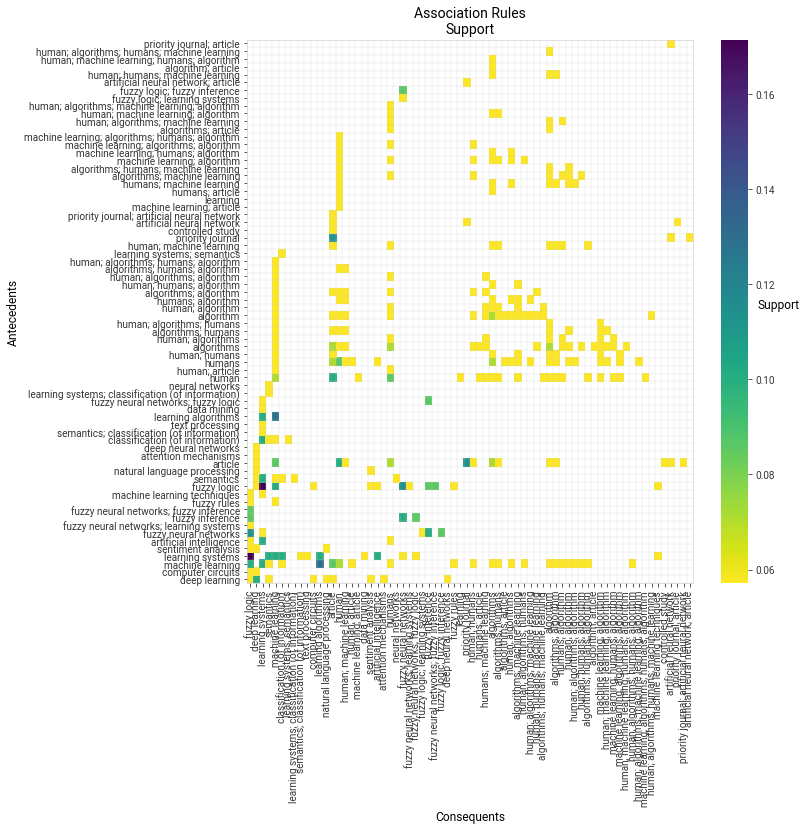

In [340]:
fig, ax = plt.subplots(figsize=(10, 10))
color_map = plt.cm.get_cmap('viridis')
reversed_color_map = color_map.reversed()

plt.hlines(y=np.arange(0, len(assd.index), 1), xmin=np.full(len(assd.index),0), xmax=np.full(len(assd.index),len(assd.index)), color="#cccccc", linewidth=.25)
plt.vlines(x=np.arange(0, len(assd.columns), 1), ymin=np.full(len(assd.index),0), ymax=np.full(len(assd.index),len(assd.index)), color="#cccccc",linewidth=.25)
plt.yticks(np.arange(0.5, len(assd.index), 1), assd.index)
plt.xticks(np.arange(0.5, len(assd.columns), 1), assd.columns, rotation=90)
plt.ylabel("Antecedents")
plt.xlabel("Consequents")
plt.title("Association Rules\nSupport")

graph=plt.pcolor(assd, cmap=reversed_color_map)
cb = fig.colorbar(graph)
cb.set_label('Support', rotation=0, va='bottom')
cb.outline.set_visible(False)
plt.show()

## Association Rules Scatterplot

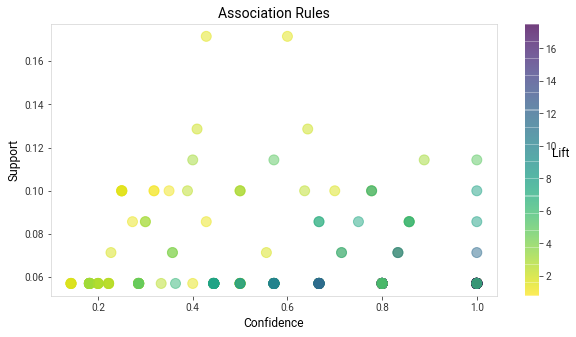

In [341]:
fig, ax = plt.subplots(figsize=(10, 5))
color_map = plt.cm.get_cmap('viridis')
reversed_color_map = color_map.reversed()
graph=plt.scatter(rules['confidence'],rules['support'],c=rules['lift'],s=100,alpha=0.5, cmap=reversed_color_map)

cb = fig.colorbar(graph)
cb.set_label('Lift', rotation=0, va='bottom')
cb.outline.set_visible(False)

plt.title('Association Rules')
plt.xlabel('Confidence')
plt.ylabel('Support')
plt.show()